In [1]:
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# EDA

In [1]:
import os, sys
scripts_dir = os.path.join(os.path.dirname(os.path.abspath('')), 'scripts')
if not scripts_dir in sys.path:
    sys.path.append(scripts_dir)
from get_graph import get_digraph
G: nx.DiGraph = get_digraph()

NameError: name 'nx' is not defined

### 1. Overall structure

In [3]:
print(f'Nodes:  {G.number_of_nodes():,}\nEdges: {G.number_of_edges():,}')
# moved to data preprocessing
# weak_components = nx.weakly_connected_components(G)
# largest_weak_component = max(weak_components, key=len)
# print(f'{nx.number_weakly_connected_components(G)} weakly connected components, largest of size {len(largest_weak_component)}')

Nodes:  27,376
Edges: 351,025


Now let's take a closer look on our citation graph and its propeties.
### 2. Degree distribution

In [4]:
in_unique, in_unique_counts = np.unique(list(dict(G.in_degree()).values()), return_counts=True)
out_unique, out_unique_counts = np.unique(list(dict(G.out_degree()).values()), return_counts=True)

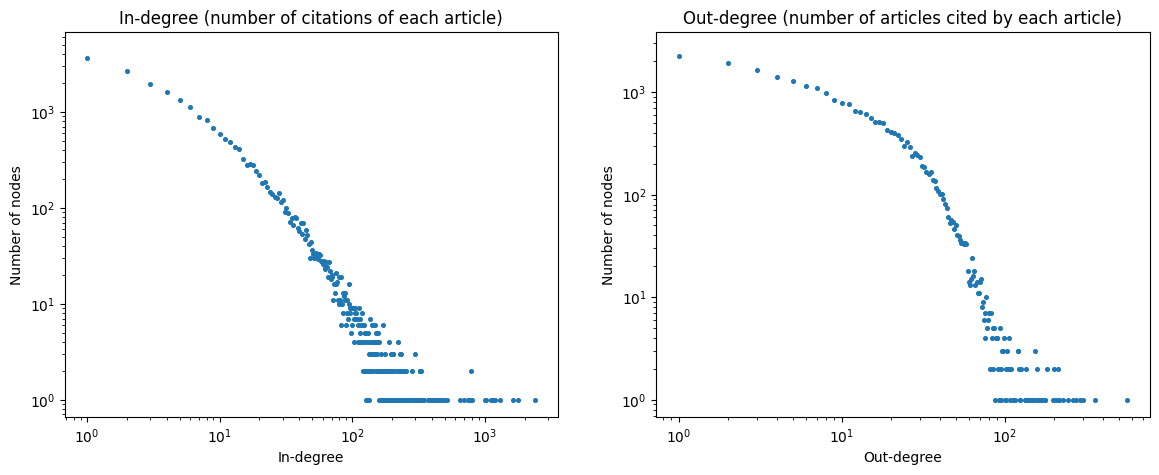

In [10]:
_, axis = plt.subplots(1, 2, figsize=(14, 5))

axis[0].scatter(in_unique, in_unique_counts, s=7)
axis[0].title.set_text('In-degree (number of citations of each article)')
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('In-degree')
axis[0].set_ylabel('Number of nodes')

axis[1].scatter(out_unique, out_unique_counts, s=7)
axis[1].title.set_text('Out-degree (number of articles cited by each article)')
axis[1].set_xscale('log')
axis[1].set_yscale('log')
axis[1].set_xlabel('Out-degree')
axis[1].set_ylabel('Number of nodes')

plt.show()

We can clearly see that our graph is a scale-free network by the in-degree. Out degree is something close to it, but a bit off. There are several explanations to it:
- There are certain conditions on how many papers should be cited by a well-written article
- It is very difficult to cite a lot of papers so the number of citations is pretty limited (usually 10-50 articles)
- If we look at it as a temporal graph: out degree of each node does not change over time after it has been added to the graph. 

### 3. Centralities
For the sake of time efficiency, we can save centralities in case we need them later

In [11]:
def open_json_if_exists_or_execute_and_save(filepath: str, func, *args) -> dict:
    if os.path.exists(filepath) and os.path.getsize(filepath) > 0:
        with open(filepath, 'r') as json_file:
            return_val = json.load(json_file)
    else:
        return_val = func(*args)
        with open(filepath, 'w') as json_file:
            json.dump(return_val, json_file)
    return return_val

In [12]:
centralities = {"eigenvector": [], "closeness": [], "betweenness": []}
graph_properties_path = os.path.join(os.pardir, 'graph_properties')

#### a) Eigenvector centralities (3sec)

In [13]:
eigenvector_centralities = open_json_if_exists_or_execute_and_save(os.path.join(graph_properties_path, 'eigenvector_centralities.json'), nx.eigenvector_centrality, G, 600)
centralities["eigenvector"] = sorted(list(eigenvector_centralities.values()), reverse=True)

In [16]:
print(f'Average eigenvector centrality: {np.mean(centralities["eigenvector"]):.6f}', 'Top 10 eigenvector centralities:', *centralities["eigenvector"][:10], sep='\n')

Average eigenvector centrality: 0.000244
Top 10 eigenvector centralities:
0.513848715786703
0.3063644052902263
0.26660711966787687
0.25314859904564324
0.2517375923483369
0.2438473348970617
0.24339749109758999
0.1682096259108627
0.1647814600132928
0.14727582627812766


#### b) Closeness centralities (6min)

In [18]:
closeness_centralities = open_json_if_exists_or_execute_and_save(os.path.join(graph_properties_path, 'closeness_centralities.json'), nx.closeness_centrality, G)
centralities["closeness"] = sorted(list(closeness_centralities.values()), reverse=True)

In [19]:
print(f'Average closeness centrality: {np.mean(centralities["closeness"]):.6f}', 'Top 10 closeness centralities:', *centralities["closeness"][:10], sep='\n')

Average closeness centrality: 0.033120
Top 10 closeness centralities:
0.23216573071788554
0.2242847097106485
0.22120624143835615
0.21507812187875708
0.21432385617640298
0.21421175965530315
0.2136583718574674
0.21294006347935385
0.20742327333205823
0.20272938603071777


#### c) Betweenness centralities (38min)

In [20]:
betweenness_centralities = open_json_if_exists_or_execute_and_save(os.path.join(graph_properties_path, 'betweenness_centralities.json'), nx.betweenness_centrality, G)
centralities["betweenness"] = sorted(list(betweenness_centralities.values()), reverse=True)

In [21]:
print(f'Average betweenness centrality: {np.mean(centralities["betweenness"]):.6f}', 'Top 10 betweenness centralities:', *centralities["betweenness"][:10], sep='\n')

Average betweenness centrality: 0.000026
Top 10 betweenness centralities:
0.023945927851609646
0.00548563896760519
0.004619401643095269
0.004126640604180482
0.003259356311471245
0.0032501859767959528
0.002956193828546459
0.0029101633645097114
0.002188873515471696
0.002120785624971369


Plot the distribution density of each centrality

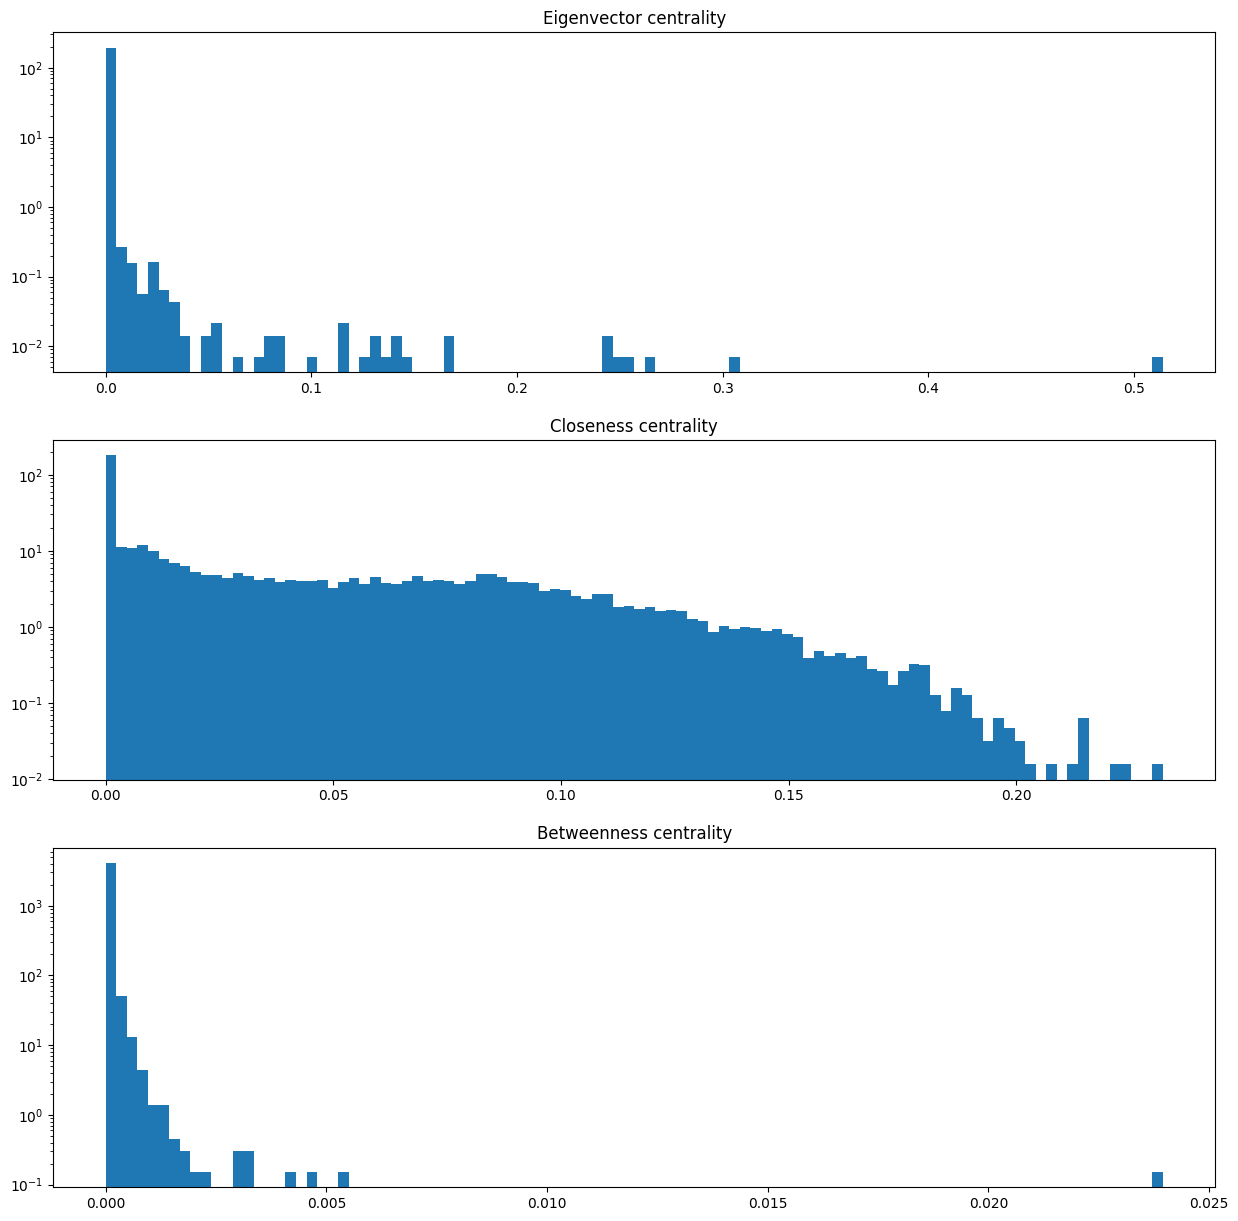

In [14]:
_, axis = plt.subplots(len(centralities), 1, figsize=(15, 5 * len(centralities)))
for i, centrality in enumerate(centralities.keys()):
    axis[i].hist(centralities[centrality], bins=100, density=True, log=True)
    axis[i].title.set_text(centrality.capitalize() + ' centrality')
plt.show()

### 4. General properties
Since some properties require the graph to be strongly connected, and our graph is not (and cannot be due to its nature), we can onli find the density of the graph and its' clustering coefficient

In [15]:
density = nx.density(G)
average_clustering = nx.average_clustering(G)
print("Graph's properties:", f"density: {density}", f"clustering coefficient: {average_clustering}", sep='\n')

Graph's properties:
density: 0.000468396809257317
clustering coefficient: 0.15601033381947366


### 5. Time properties

Since we can look at our graph as a temporal graph, we can consider some of its temporal features. Firstly, there should be no edge ($u \rightarrow v$), where paper $v$ was published after paper $u$ had been published (since you cannot cite papers that are not yet published). We have already verified this condition. Secondly, this also leads to lack of cycles in our graph and number of strongly connected components matching the number of nodes $n$:

In [16]:
# WARNING: takes 28 minutes
try:
    print(nx.find_cycle(G, orientation='original'))
except nx.NetworkXNoCycle:
    print('No cycles found.')

No cycles found.


In [17]:
print(f'Number of strongly connected components in G: {nx.number_strongly_connected_components(G)}')
print(f'Number of nodes in G:                         {G.number_of_nodes()}')

Number of strongly connected components in G: 27376
Number of nodes in G:                         27376


Let's look at how our temporal graph changes over time: we will plot the number of new papers by time. This is more convenient to do with the DataFrame with information about papers than the graph.

In [18]:
df = pd.read_csv(os.path.join(os.pardir, 'data', 'processed.csv')).set_index('Paper_ID').drop(columns=['Unnamed: 0'])
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df[df.index.isin(G.nodes)]

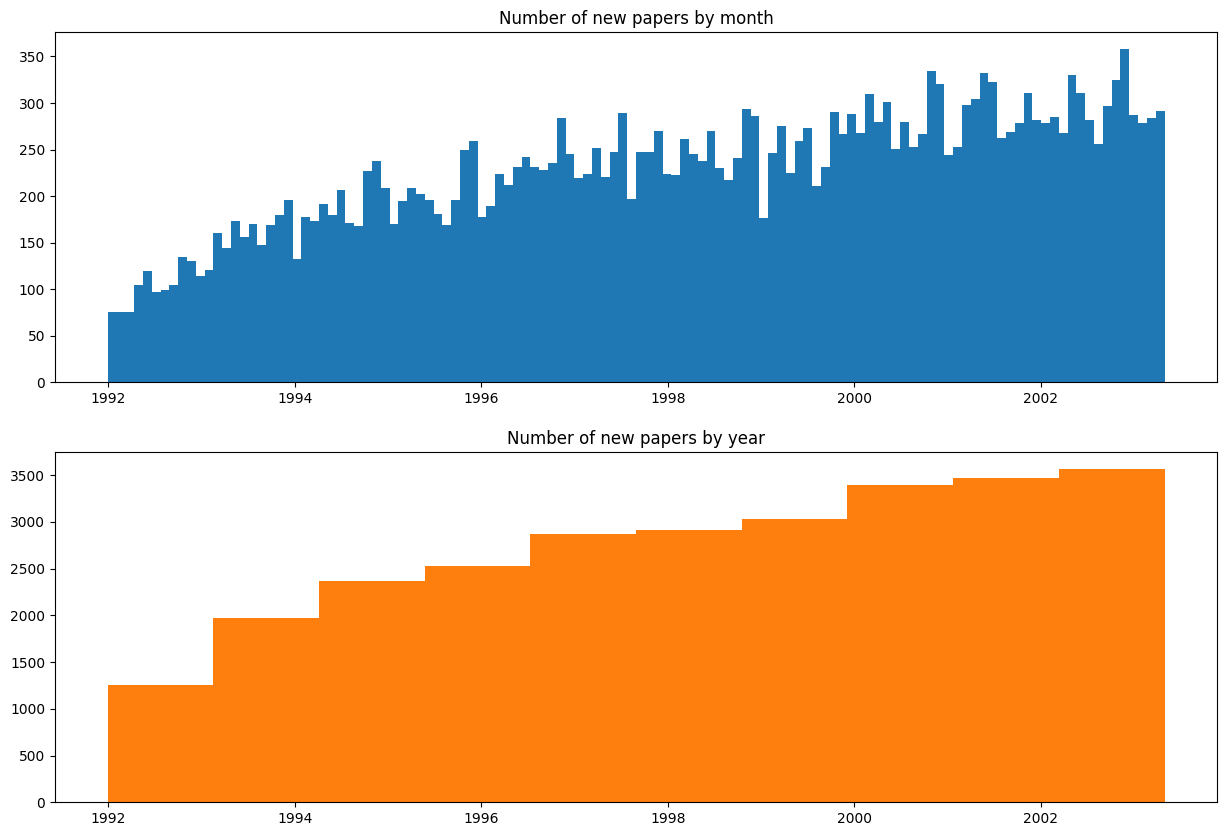

In [22]:
_, axis = plt.subplots(2, 1, figsize=(15, 10))
axis[0].hist(df['Date'], bins=10*12)
axis[0].title.set_text('Number of new papers by month')
axis[1].hist(df['Date'], bins=10, color='C1')
axis[1].title.set_text('Number of new papers by year')
plt.show()

We can clearly see that the number of papers steadily increased over the years. Let's also look at how average number of papers cited by a paper and average citation rate changed over time

In [20]:
df['In_degree'] = df.index.map(dict(G.in_degree())).astype(int)
df['Out_degree'] = df.index.map(dict(G.out_degree())).astype(int)

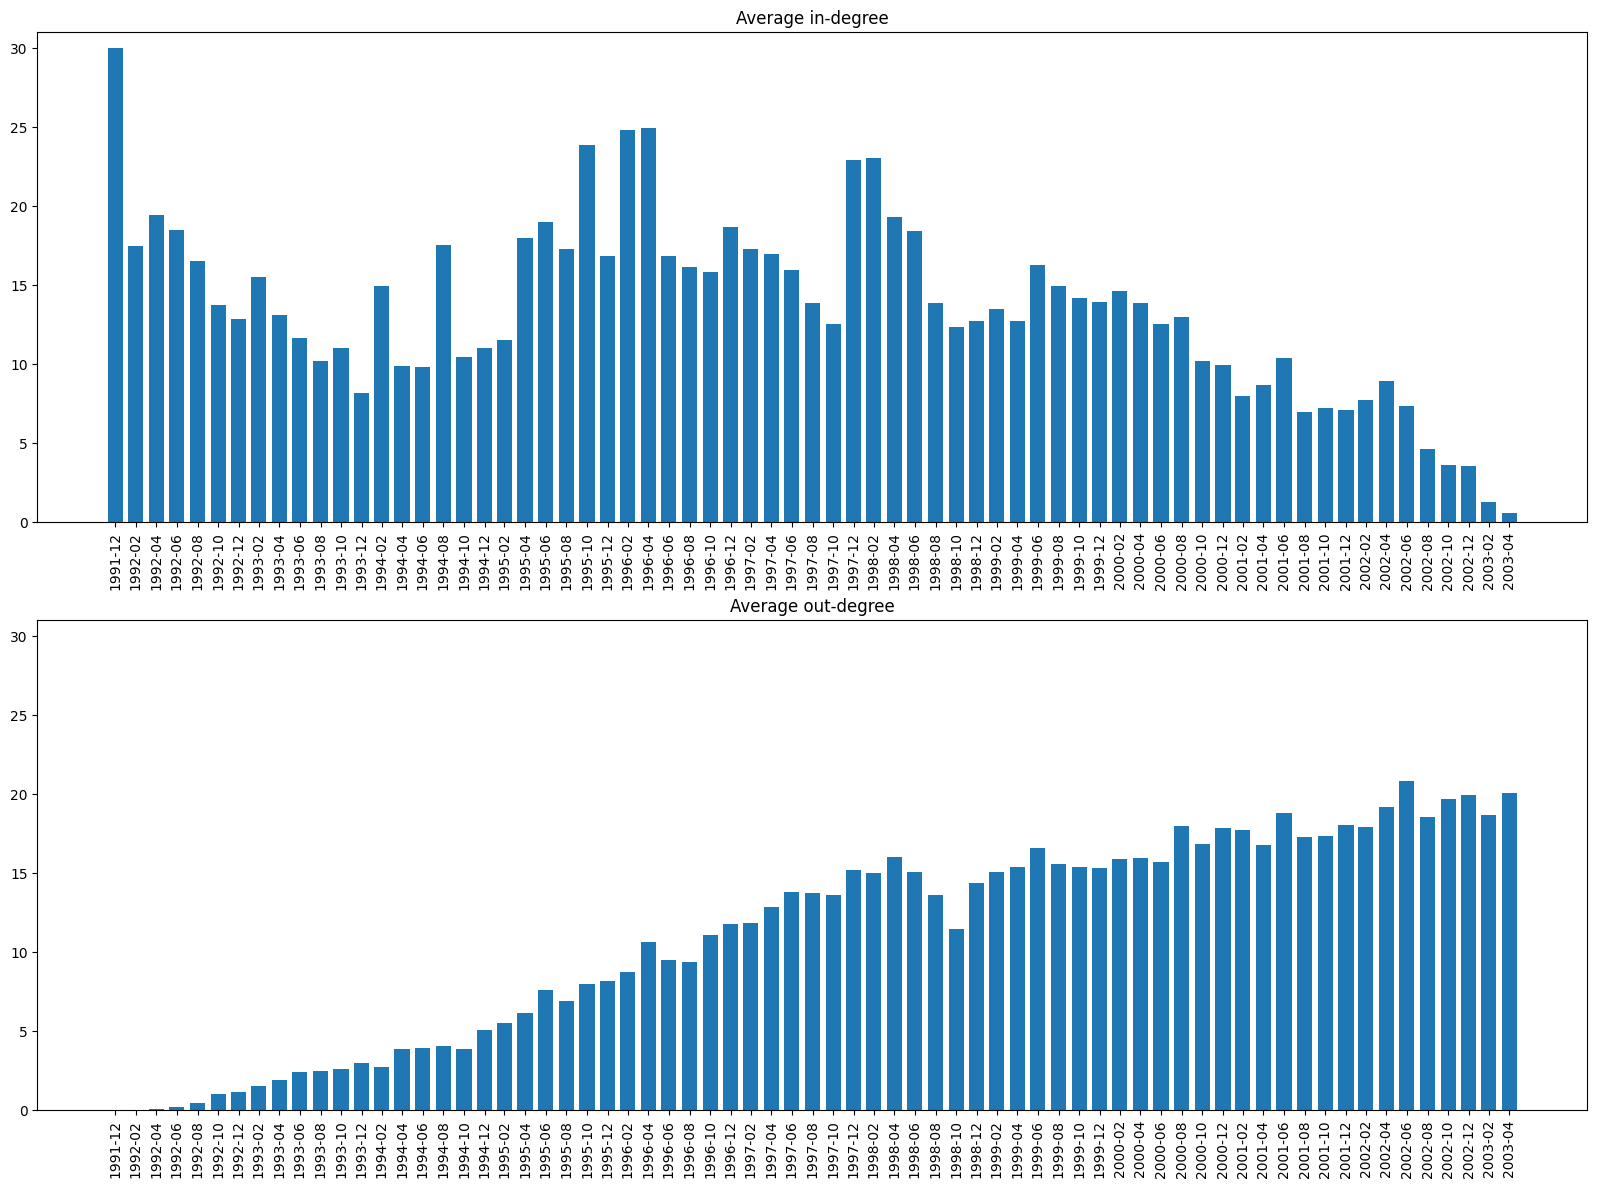

In [21]:
in_degs = df.resample('2ME', on='Date')['In_degree'].apply(np.mean)
out_degs = df.resample('2ME', on='Date')['Out_degree'].apply(np.mean)

dates_formatter = mdates.DateFormatter('%Y-%m')
fig, axis = plt.subplots(2, 1, figsize=(20, 14))

for i, degs in enumerate({"in": in_degs, "out": out_degs}.items()):
    axis[i].bar(degs[1].index, list(degs[1]), width=45, tick_label=degs[1].index)
    axis[i].xaxis.set_major_formatter(dates_formatter)
    axis[i].tick_params(axis='x', labelrotation=90)
    axis[i].title.set_text("Average " + degs[0] + "-degree")
    axis[i].set_ylim((0, 31))

The overall downwards trend in 'in degree' and upwards trend in 'out degree' can be explained this way: since we only take into account a part of all existing papers on high energy physics, the number of relevant to a certain paper articles is 0  in the beginning (it does not mean that they do not cite any papers, we just do not have them in our graph) and is growing over time, until it starts to exceed the number of needed sources for an average paper (this is why the growth slows down in the end). The opposite happens with the 'in degree': older papers had more time to gain citations and last papers just did not have many newer articles to cite them.